In [3]:
!wget https://github.com/radical-experiments/deepdriveMD/blob/master/data/async/re.session.login3.braceal.018603.0006.tar.gz?raw=true

--2020-12-18 13:28:27--  https://github.com/radical-experiments/deepdriveMD/blob/master/data/async/re.session.login3.braceal.018603.0006.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/radical-experiments/deepdriveMD/raw/master/data/async/re.session.login3.braceal.018603.0006.tar.gz [following]
--2020-12-18 13:28:27--  https://github.com/radical-experiments/deepdriveMD/raw/master/data/async/re.session.login3.braceal.018603.0006.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/radical-experiments/deepdriveMD/master/data/async/re.session.login3.braceal.018603.0006.tar.gz [following]
--2020-12-18 13:28:28--  https://raw.githubusercontent.com/radical-experiments/deepdriveMD/master/data/async/re.session.login3.braceal.018603.0006

In [ ]:
!tar xzf re.session.login3.braceal.018603.0006.tar.gz*

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [10]:
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
sid = 're.session.login3.braceal.018603.0006'
session = ra.Session(sid, "radical.pilot")

In [13]:
from datetime import datetime
import time
d=datetime(2020,12,10,19,35,0)
unixtime = time.mktime(d.timetuple())

In [11]:
units = session.get(etype='unit')
stages = {}
for unit in units:
    tid, tname, sid, sname, pid, pname = (unit.description['name'].split(','))
    try:
        stages[sid]['stime'] = min(stages[sid]['stime'], unit.timestamps(event={ru.EVENT:'cu_exec_start'})[0])
        stages[sid]['etime'] = max(stages[sid]['etime'], unit.timestamps(event={ru.EVENT:'cu_exec_stop'})[0])
    except:
        stages[sid] = { 
            'stime': unit.timestamps(event={ru.EVENT:'cu_exec_start'})[0],
            'etime': unit.timestamps(event={ru.EVENT:'cu_exec_stop'})[0],
            'sid': sid,
            'sname': sname
        }

In [31]:
data = []
iter_cnt = 0
prev_sname = ''
init_time = units[0].timestamps(event={ru.EVENT:'cu_exec_start'})[0]
for unit in units:
    tid, tname, sid, sname, pid, pname = (unit.description['name'].split(','))
    if sname == 'MD' and prev_sname != 'MD':
        iter_cnt += 1
    prev_sname = sname
    tidx = int(tid.split(".")[1])
    stime = unit.timestamps(event={ru.EVENT:'cu_exec_start'})[0] - init_time
    etime = unit.timestamps(event={ru.EVENT:'cu_exec_stop'})[0] - init_time
    elapsed = etime - stime
    sdate = datetime.fromtimestamp(stime + unixtime)
    edate = datetime.fromtimestamp(etime + unixtime)
    data.append([tidx, tid, tname, sid, sname, pid, pname, iter_cnt, stime, etime, elapsed, sdate, edate])

In [44]:
stage_idx = 4
iter_idx = 7
stime_idx = 8
etime_idx = 9
elapsed_idx = 10
data_p = {}
for d in data:
    if not d[stage_idx] in data_p:
        data_p[d[stage_idx]] = [(float('inf'),0)] * 9
    exist_stime = data_p[d[stage_idx]][d[iter_idx] - 1][0]
    exist_elapsed = data_p[d[stage_idx]][d[iter_idx] - 1][1]
    data_p[d[stage_idx]][d[iter_idx] - 1] = (min(exist_stime, d[stime_idx]), max(exist_elapsed, d[elapsed_idx]))
    

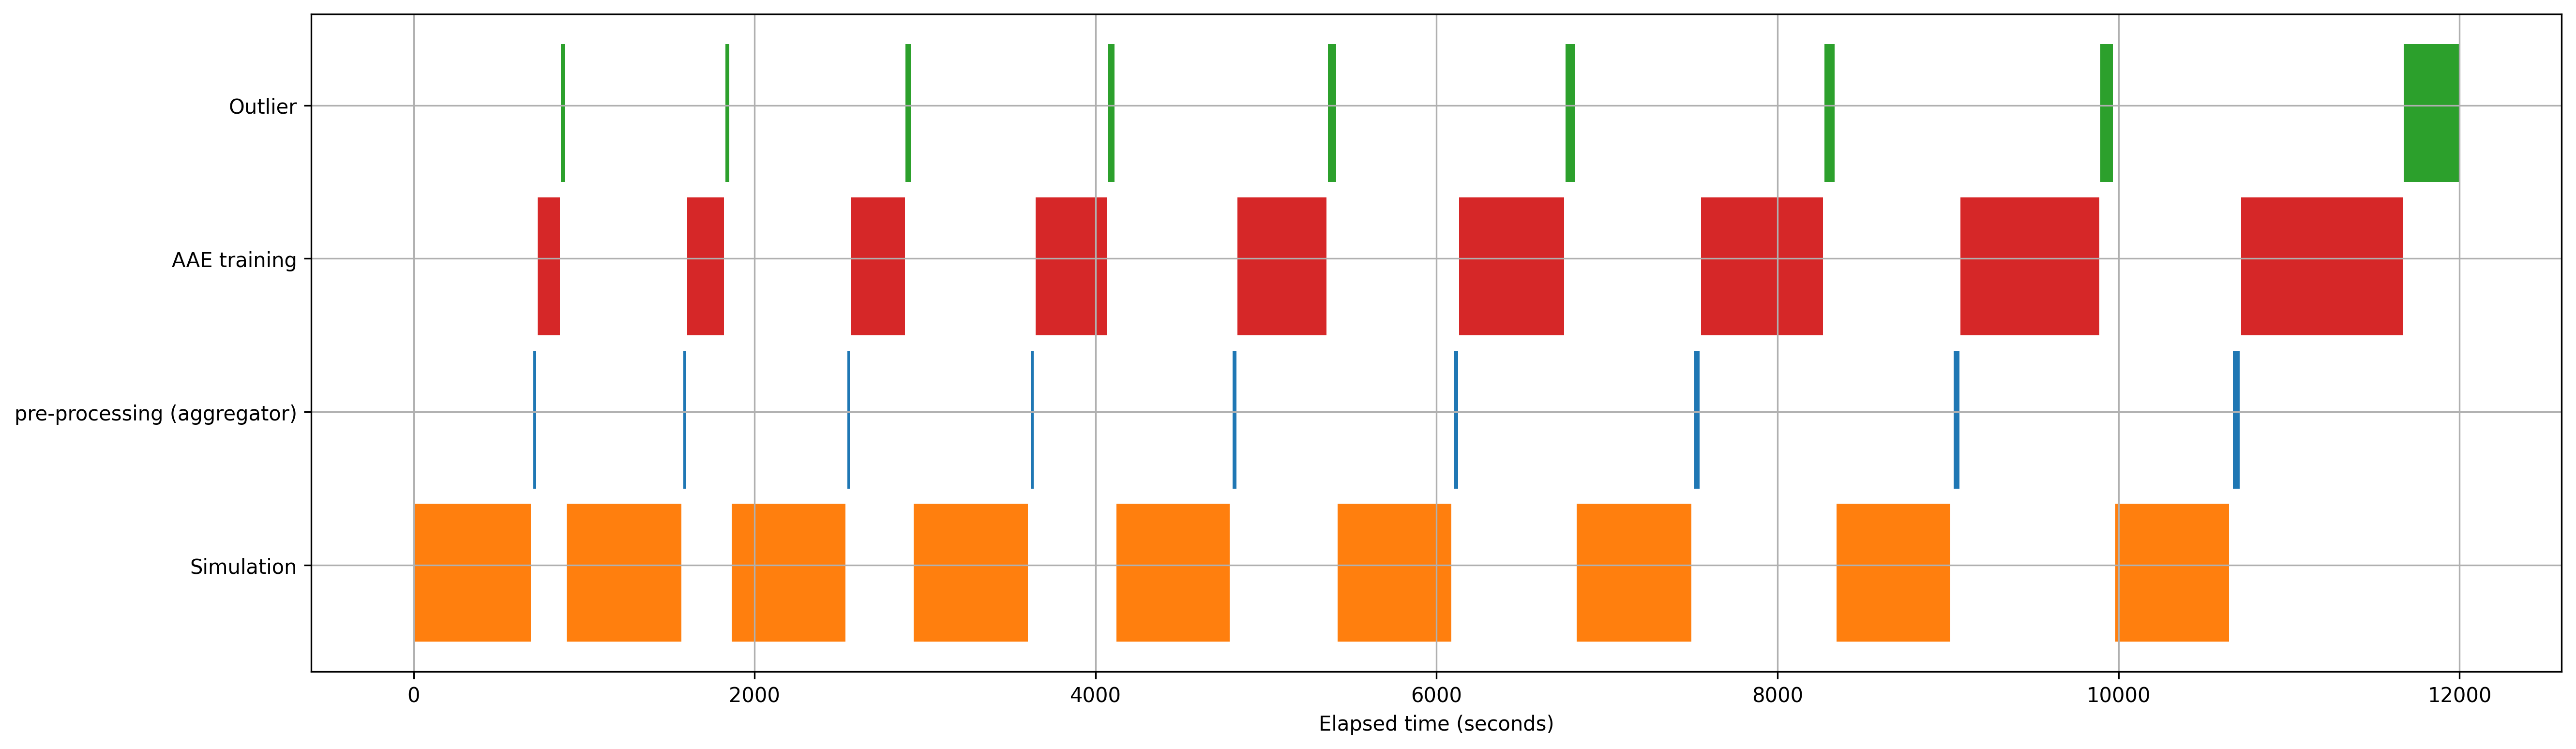

In [60]:
import matplotlib.pyplot as plt 
fig, gnt = plt.subplots(figsize=(20, 6), dpi=300) 
  
# Setting Y-axis limits 
#gnt.set_ylim(0, 50) 
  
# Setting X-axis limits 
#gnt.set_xlim(0, 160) 
  
# Setting labels for x-axis and y-axis 
gnt.set_xlabel('Elapsed time (seconds)') 
gnt.set_ylabel('') 
  
# Setting ticks on y-axis 
gnt.set_yticks([15, 25, 35, 45]) 
# Labelling tickes of y-axis 
gnt.set_yticklabels(['Simulation', 'pre-processing (aggregator)', 'AAE training', 'Outlier']) 
  
# Setting graph attribute 
gnt.grid(True) 
  
# Declaring a bar in schedule 
gnt.broken_barh(data_p['MD'], (10, 9), facecolors =('tab:orange')) 
  
# Declaring multiple bars in at same level and same width 
gnt.broken_barh(data_p['aggregating'], (20, 9), 
                         facecolors ='tab:blue') 
  
gnt.broken_barh(data_p['learning'], (30, 9), 
                                  facecolors =('tab:red')) 

gnt.broken_barh(data_p['scanning'], (40, 9), 
                                  facecolors =('tab:green')) 
  
plt.savefig("gantt1.png") 